In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parulpandey/palmer-archipelago-antarctica-penguin-data")

print("Path to dataset files:", path)

Path to dataset files: /home/ikx/.cache/kagglehub/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data/versions/1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from tabulate import tabulate
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from itertools import combinations
import statsmodels.api as sm

In [34]:
df = pd.read_csv(path + '/penguins_size.csv')

In [35]:
def dataframe_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """
    –í—ã–ø–æ–ª–Ω—è–µ—Ç –æ—á–∏—Å—Ç–∫—É –¥–∞—Ç–∞—Å–µ—Ç–∞ –æ—Ç –ø—Ä–æ–ø—É—Å–∫–æ–≤ –∏ –Ω–µ–∫–æ—Ä—Ä–µ–∫—Ç–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π.
    """
    df = df.dropna()
    df = df[df['sex'] != '.']
    return df

def dataset_report(df: pd.DataFrame, top_n: int = None):
    """
    –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Å–≤–æ–¥–Ω–æ–π —Ç–∞–±–ª–∏—Ü—ã –ø–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º—É:
    - –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: min, max, mean
    - –¥–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ (–≤—Å–µ –∏–ª–∏ top_n –∑–Ω–∞—á–µ–Ω–∏–π)
    
    :param df: DataFrame –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞
    :param top_n: –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ –Ω–∞ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–≤–æ–¥–∏–º—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π (–Ω–∞–ø—Ä–∏–º–µ—Ä, top_n=5)
    """
    info = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            info.append([
                col,
                str(df[col].dtype),
                df[col].isna().sum(),
                round(df[col].isna().mean()*100, 2),
                df[col].nunique(),
                df[col].min(),
                df[col].max(),
                round(df[col].mean(), 2) if df[col].notna().any() else "-",
                "-"
            ])
        else:
            # —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞
            vc = df[col].value_counts(dropna=False)
            if top_n is not None and len(vc) > top_n:
                top = vc.head(top_n)
                other_sum = vc.iloc[top_n:].sum()
                dist = dict(top)
                dist["Other"] = other_sum
            else:
                dist = dict(vc)
            dist_str = ", ".join([f"{k}: {v}" for k, v in dist.items()])
            info.append([
                col,
                str(df[col].dtype),
                df[col].isna().sum(),
                round(df[col].isna().mean()*100, 2),
                df[col].nunique(),
                "-",
                "-",
                "-",
                dist_str
            ])
    
    headers = [
        "–ö–æ–ª–æ–Ω–∫–∞", "–¢–∏–ø", "–ü—Ä–æ–ø—É—Å–∫–∏", "% –ø—Ä–æ–ø—É—Å–∫–æ–≤",
        "–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ", "–ú–∏–Ω", "–ú–∞–∫—Å", "–°—Ä–µ–¥–Ω–µ–µ", "–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ"
    ]
    
    print("–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞:", df.shape)
    print(tabulate(info, headers=headers, tablefmt="grid"))


def correlation_table(df, features):
    """
    –í—ã—á–∏—Å–ª—è–µ—Ç –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –ü–∏—Ä—Å–æ–Ω–∞ –∏ –°–ø–∏—Ä–º–µ–Ω–∞ –¥–ª—è –≤—Å–µ—Ö –ø–∞—Ä —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    –∏ –≤—ã–≤–æ–¥–∏—Ç —Ç–∞–±–ª–∏—Ü—É —á–µ—Ä–µ–∑ tabulate.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    -----------
    df : DataFrame
        –¢–∞–±–ª–∏—Ü–∞ —Å –¥–∞–Ω–Ω—ã–º–∏
    features : list[str]
        –°–ø–∏—Å–æ–∫ —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    """
    
    results = []

    for f1, f2 in combinations(features, 2):
        subset = df[[f1, f2]].dropna()
        x, y = subset[f1], subset[f2]

        # –ü–∏—Ä—Å–æ–Ω
        r_p, p_p = pearsonr(x, y)
        # –°–ø–∏—Ä–º–µ–Ω
        r_s, p_s = spearmanr(x, y)

        results.append([
            f1,
            f2,
            round(r_p, 3),
            round(p_p, 5),
            round(r_s, 3),
            round(p_s, 5)
        ])

    # –¢–∞–±–ª–∏—Ü–∞ DataFrame
    corr_table = pd.DataFrame(results, columns=[
        "–ü—Ä–∏–∑–Ω–∞–∫ 1", "–ü—Ä–∏–∑–Ω–∞–∫ 2", "–ü–∏—Ä—Å–æ–Ω r", "p-value (–ü–∏—Ä—Å–æ–Ω)", "–°–ø–∏—Ä–º–µ–Ω œÅ", "p-value (–°–ø–∏—Ä–º–µ–Ω)"
    ])

    # –í—ã–≤–æ–¥ —á–µ—Ä–µ–∑ tabulate
    print(tabulate(corr_table, headers='keys', tablefmt='grid', showindex=False))

    # return corr_table



In [36]:
def plot_pairwise(df, features, target, diag="hist"):
    """
    –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø–æ –≤—Å–µ–º –ø–∞—Ä–∞–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    -----------
    df : DataFrame
        –¢–∞–±–ª–∏—Ü–∞ —Å –¥–∞–Ω–Ω—ã–º–∏
    features : list[str]
        –°–ø–∏—Å–æ–∫ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞
    target : str
        –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è (–∫–ª–∞—Å—Å—ã, –Ω–∞–ø—Ä–∏–º–µ—Ä species)
    diag : {"hist", "kde"}, default="hist"
        –ß—Ç–æ —Ä–∏—Å–æ–≤–∞—Ç—å –Ω–∞ –¥–∏–∞–≥–æ–Ω–∞–ª–∏: –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—É –∏–ª–∏ –ø–ª–æ—Ç–Ω–æ—Å—Ç—å
    """
    
    # –¥–æ—Å—Ç—É–ø–Ω—ã–µ –º–∞—Ä–∫–µ—Ä—ã
    marker_styles = ["o", "s", "D", "^", "v", "X", "P", "*", "H", "<", ">"]
    
    # –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Å–æ–≤
    n_classes = df[target].nunique()
    
    # –±–µ—Ä—ë–º —Å—Ç–æ–ª—å–∫–æ —Ñ–æ—Ä–º, —Å–∫–æ–ª—å–∫–æ –Ω—É–∂–Ω–æ
    markers = marker_styles[:n_classes]
    
    sns.pairplot(
        df[features + [target]],
        hue=target,                      # —Ü–≤–µ—Ç –ø–æ –∫–ª–∞—Å—Å–∞–º
        diag_kind=diag,                  # –¥–∏–∞–≥–æ–Ω–∞–ª—å: hist –∏–ª–∏ kde
        markers=markers,                 # –∞–¥–∞–ø—Ç–∏–≤–Ω—ã–π –≤—ã–±–æ—Ä —Ñ–æ—Ä–º
        diag_kws={"bins": 20, "edgecolor": "k"} if diag=="hist" else {},
        plot_kws={"alpha": 0.7, "s": 40}  # –ø—Ä–æ–∑—Ä–∞—á–Ω–æ—Å—Ç—å –∏ —Ä–∞–∑–º–µ—Ä —Ç–æ—á–µ–∫
    )
    
    plt.show()

def heatmap_corr(df_sub, features, title="–ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω—ã–µ –º–∞—Ç—Ä–∏—Ü—ã"):
    """
    –°—Ç—Ä–æ–∏—Ç 2 —Ç–µ–ø–ª–æ–≤—ã–µ –∫–∞—Ä—Ç—ã –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π (–ü–∏—Ä—Å–æ–Ω –∏ –°–ø–∏—Ä–º–∞–Ω) —Ä—è–¥–æ–º.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    -----------
    df_sub : DataFrame
        –î–∞—Ç–∞—Å–µ—Ç
    features : list[str]
        –°–ø–∏—Å–æ–∫ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    title : str
        –ó–∞–≥–æ–ª–æ–≤–æ–∫ –¥–ª—è –≤—Å–µ–π —Ñ–∏–≥—É—Ä—ã
    """
    corr_pearson = df_sub[features].corr(method="pearson")
    corr_spearman = df_sub[features].corr(method="spearman")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm",
                vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title("–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è (–ü–∏—Ä—Å–æ–Ω)")

    sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm",
                vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title("–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è (–°–ø–∏—Ä–º–∞–Ω)")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


def pairplot_with_regression(df, class_col, features):
    """
    –°—Ç—Ä–æ–∏—Ç —Å–µ—Ç–∫—É –≥—Ä–∞—Ñ–∏–∫–æ–≤ (–∞–Ω–∞–ª–æ–≥ sns.pairplot) –¥–ª—è –≤—Å–µ—Ö –ø–∞—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤.
    –í –Ω–µ–ø–∞—Ä–Ω—ã—Ö –∫–ª–µ—Ç–∫–∞—Ö - scatter + —Ä–µ–≥—Ä–µ—Å—Å–∏—è + 95% PI.
    –ù–∞ –¥–∏–∞–≥–æ–Ω–∞–ª–∏ - –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã.
    """

    n = len(features)
    classes = df[class_col].dropna().unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

    fig, axes = plt.subplots(n, n, figsize=(4*n, 4*n))

    for i, f1 in enumerate(features):
        for j, f2 in enumerate(features):

            ax = axes[i, j]

            # –î–∏–∞–≥–æ–Ω–∞–ª—å: –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞
            if i == j:
                for c, col in zip(classes, colors):
                    subset = df[df[class_col] == c][f1].dropna()
                    ax.hist(subset, bins=20, alpha=0.5, color=col, label=c)
                ax.set_xlabel(f1)
                ax.set_ylabel("–ß–∞—Å—Ç–æ—Ç–∞")

            else:
                # Scatterplot —Å —Ä–∞–∑–Ω—ã–º–∏ –∫–ª–∞—Å—Å–∞–º–∏
                for c, col in zip(classes, colors):
                    subset = df[df[class_col] == c][[f1, f2]].dropna()
                    ax.scatter(subset[f1], subset[f2], alpha=0.6, color=col, label=c)

                # –õ–∏–Ω–∏—è —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ (–ø–æ –≤—Å–µ–º –¥–∞–Ω–Ω—ã–º)
                subset = df[[f1, f2]].dropna()
                if not subset.empty:
                    X = subset[f1]
                    y = subset[f2]
                    X_const = sm.add_constant(X)
                    model = sm.OLS(y, X_const).fit()

                    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
                    x_pred = np.linspace(X.min(), X.max(), 200)
                    X_pred_const = sm.add_constant(x_pred)
                    pred = model.get_prediction(X_pred_const)
                    pred_summary = pred.summary_frame(alpha=0.05)

                    # –õ–∏–Ω–∏—è —Ä–µ–≥—Ä–µ—Å—Å–∏–∏
                    ax.plot(x_pred, pred_summary["mean"], color="red")

                    # –ü—Ä–æ–≥–Ω–æ–∑–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª
                    ax.fill_between(
                        x_pred,
                        pred_summary["obs_ci_lower"],
                        pred_summary["obs_ci_upper"],
                        color="red",
                        alpha=0.2
                    )

                ax.set_xlabel(f1)
                ax.set_ylabel(f2)

            # –¢–æ–ª—å–∫–æ –≤ –ø–µ—Ä–≤–æ–π —Å—Ç—Ä–æ–∫–µ –ø–æ–∫–∞–∑—ã–≤–∞–µ–º –ª–µ–≥–µ–Ω–¥—É
            if i == 0 and j == n-1:
                ax.legend()

    plt.tight_layout()
    plt.show()

In [37]:
"""
–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –∏—Å—Ö–æ–¥–Ω–æ–º—É –¥–∞—Ç–∞—Å–µ—Ç—É
"""
dataset_report(df)

–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞: (344, 7)
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| –ö–æ–ª–æ–Ω–∫–∞           | –¢–∏–ø     |   –ü—Ä–æ–ø—É—Å–∫–∏ |   % –ø—Ä–æ–ø—É—Å–∫–æ–≤ |   –£–Ω–∏–∫–∞–ª—å–Ω—ã–µ | –ú–∏–Ω    | –ú–∞–∫—Å   | –°—Ä–µ–¥–Ω–µ–µ   | –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ                           |
+===================+=========+============+===============+==============+========+========+===========+=========================================+
| species           | object  |          0 |          0    |            3 | -      | -      | -         | Adelie: 152, Gentoo: 124, Chinstrap: 68 |
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| island            | object  |          0 |          0    |            3 | -      | -      | -         | Biscoe: 168, Dream: 124, Torgersen: 52  |
+-------

In [38]:
"""
–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ —á–∏—Å—Ç–æ–º—É –¥–∞—Ç–∞—Å–µ—Ç—É
"""
df = dataframe_cleaning(df)
dataset_report(df)

–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞: (333, 7)
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| –ö–æ–ª–æ–Ω–∫–∞           | –¢–∏–ø     |   –ü—Ä–æ–ø—É—Å–∫–∏ |   % –ø—Ä–æ–ø—É—Å–∫–æ–≤ |   –£–Ω–∏–∫–∞–ª—å–Ω—ã–µ | –ú–∏–Ω    | –ú–∞–∫—Å   | –°—Ä–µ–¥–Ω–µ–µ   | –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ                           |
+===================+=========+============+===============+==============+========+========+===========+=========================================+
| species           | object  |          0 |             0 |            3 | -      | -      | -         | Adelie: 146, Gentoo: 119, Chinstrap: 68 |
+-------------------+---------+------------+---------------+--------------+--------+--------+-----------+-----------------------------------------+
| island            | object  |          0 |             0 |            3 | -      | -      | -         | Biscoe: 163, Dream: 123, Torgersen: 47  |
+-------


–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –∫–ª–∞—Å—Å–∞–º: species


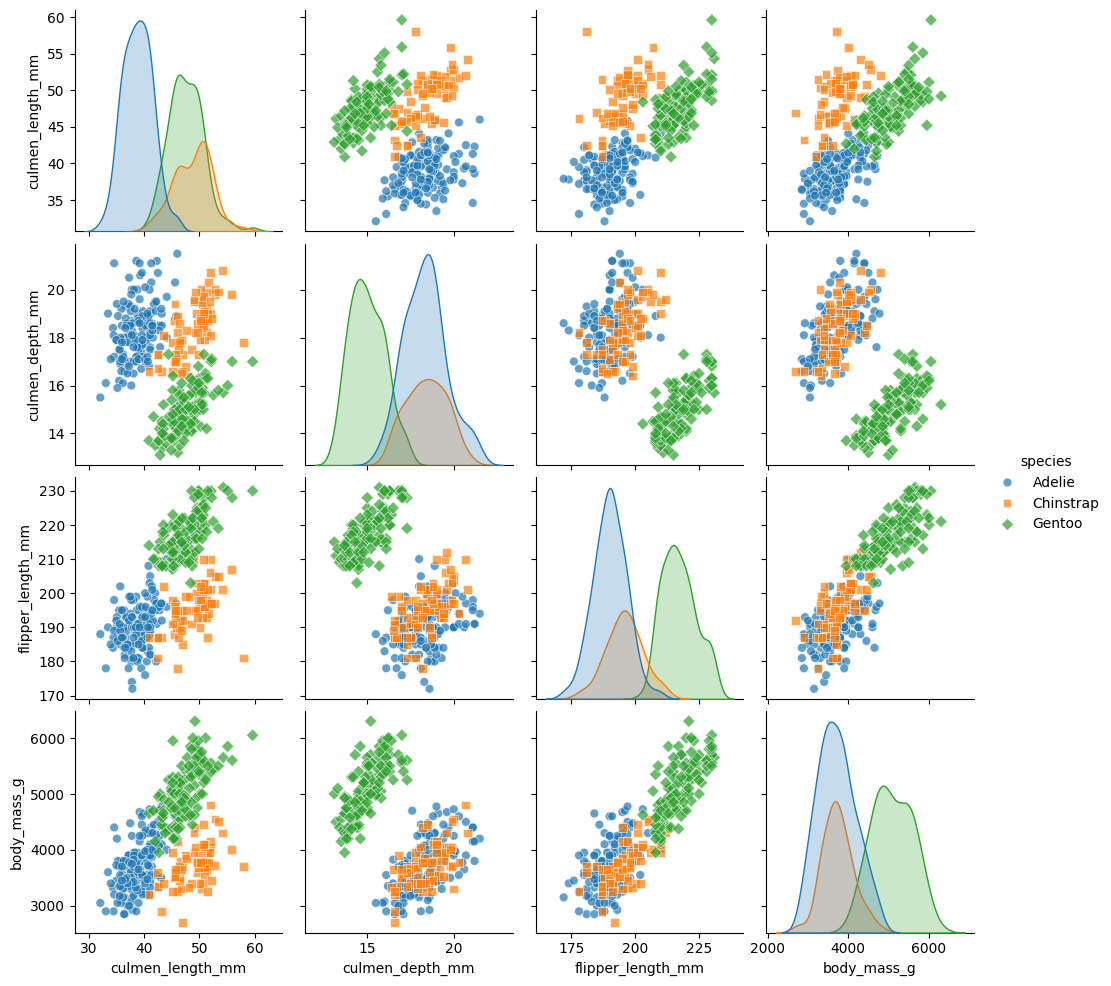


–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –∫–ª–∞—Å—Å–∞–º: island


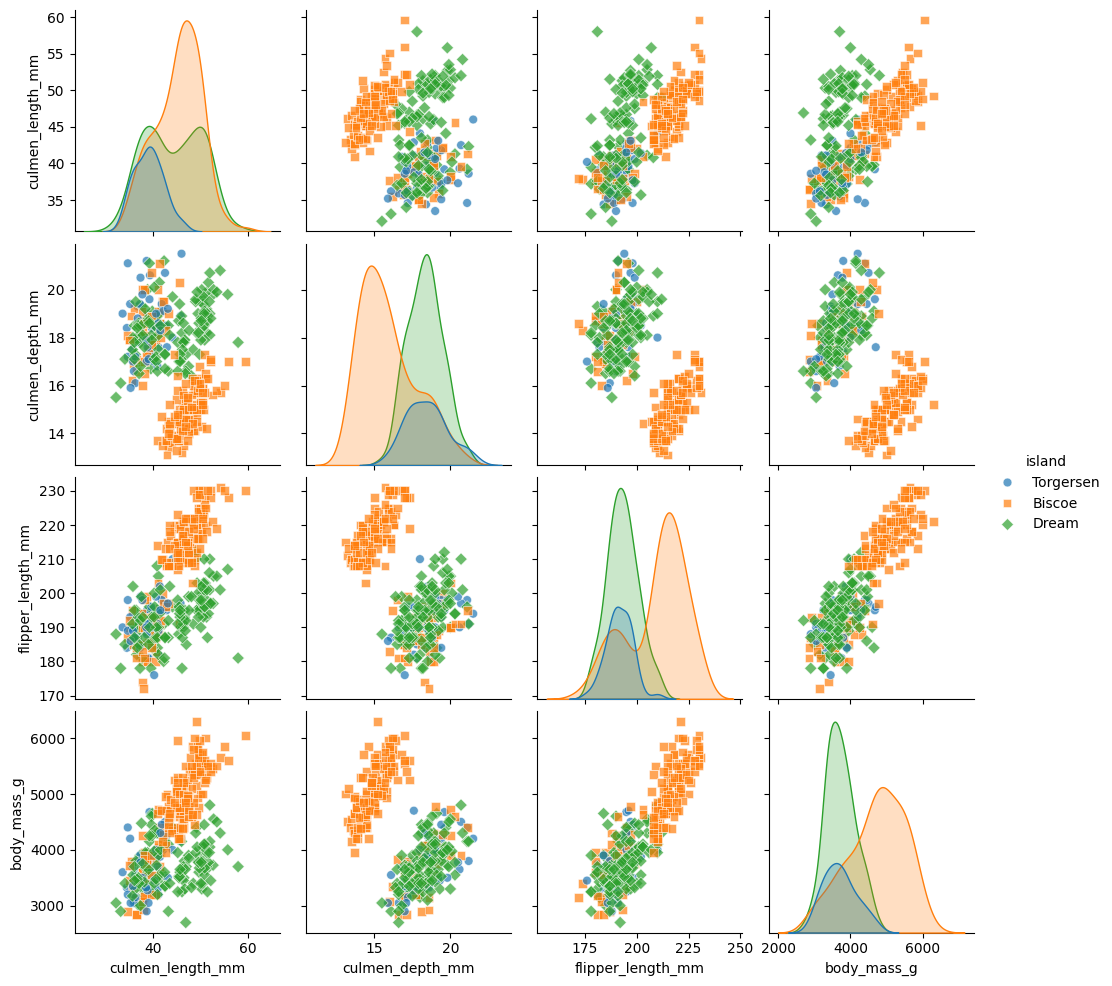


–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –∫–ª–∞—Å—Å–∞–º: sex


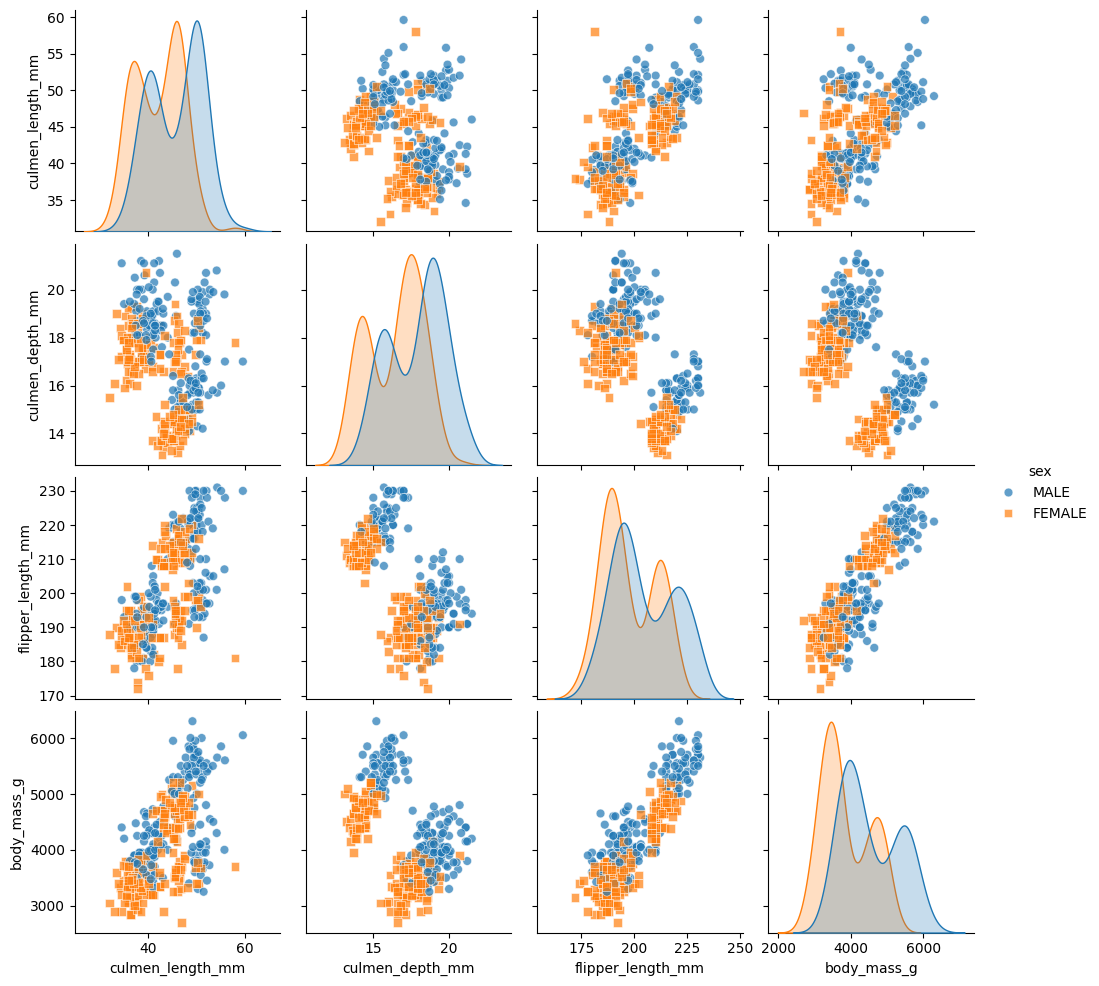

In [39]:
"""
–ü–æ–ø–∞—Ä–Ω–∞—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ç–∞—Ä–≥–µ—Ç–∞
"""

features = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]
targets = ["species", "island", "sex"]

for target in targets:
    print(f"\n–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –∫–ª–∞—Å—Å–∞–º: {target}")
    plot_pairwise(df, features, target, diag="kde")


=== –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –Ω–∞ –≤—Å–µ–º –¥–∞—Ç–∞—Å–µ—Ç–µ ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| –ü—Ä–∏–∑–Ω–∞–∫ 1         | –ü—Ä–∏–∑–Ω–∞–∫ 2         |   –ü–∏—Ä—Å–æ–Ω r |   p-value (–ü–∏—Ä—Å–æ–Ω) |   –°–ø–∏—Ä–º–µ–Ω œÅ |   p-value (–°–ø–∏—Ä–º–µ–Ω) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.229 |              3e-05 |      -0.214 |               8e-05 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.653 |              0     |       0.67  |               0     |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.589 |              0     |       0.576 |               0     |
+--

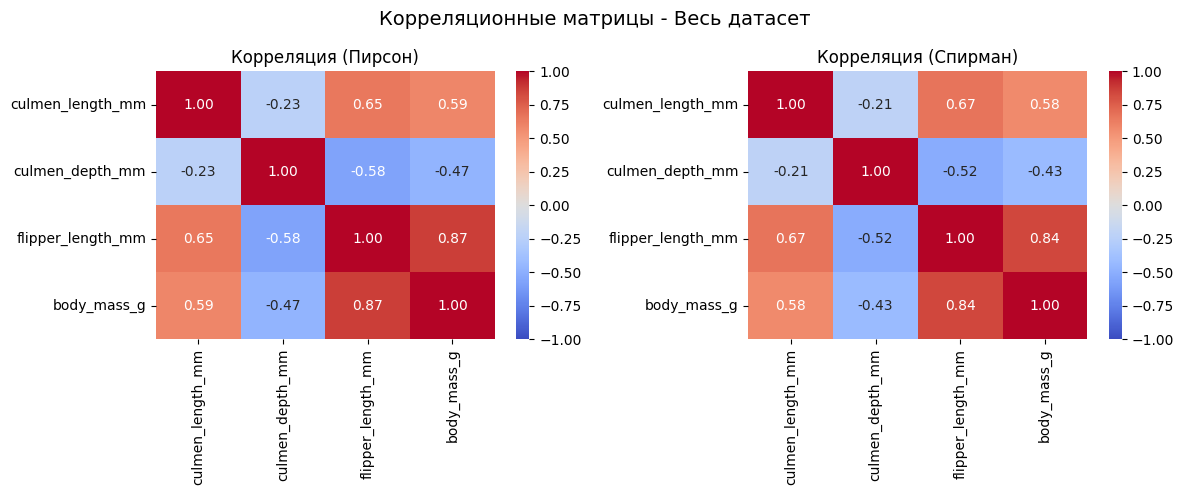

In [40]:
print("=== –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –Ω–∞ –≤—Å–µ–º –¥–∞—Ç–∞—Å–µ—Ç–µ ===")
correlation_table(df, features)
heatmap_corr(df, features, title="–ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω—ã–µ –º–∞—Ç—Ä–∏—Ü—ã - –í–µ—Å—å –¥–∞—Ç–∞—Å–µ—Ç")



–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –ø–æ –∫–ª–∞—Å—Å—É: species

=== –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –¥–ª—è –æ–±—å–µ–∫—Ç–æ–≤: Adelie ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| –ü—Ä–∏–∑–Ω–∞–∫ 1         | –ü—Ä–∏–∑–Ω–∞–∫ 2         |   –ü–∏—Ä—Å–æ–Ω r |   p-value (–ü–∏—Ä—Å–æ–Ω) |   –°–ø–∏—Ä–º–µ–Ω œÅ |   p-value (–°–ø–∏—Ä–º–µ–Ω) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.386 |            0       |       0.355 |               1e-05 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.332 |            4e-05   |       0.348 |               2e-05 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.544 |         

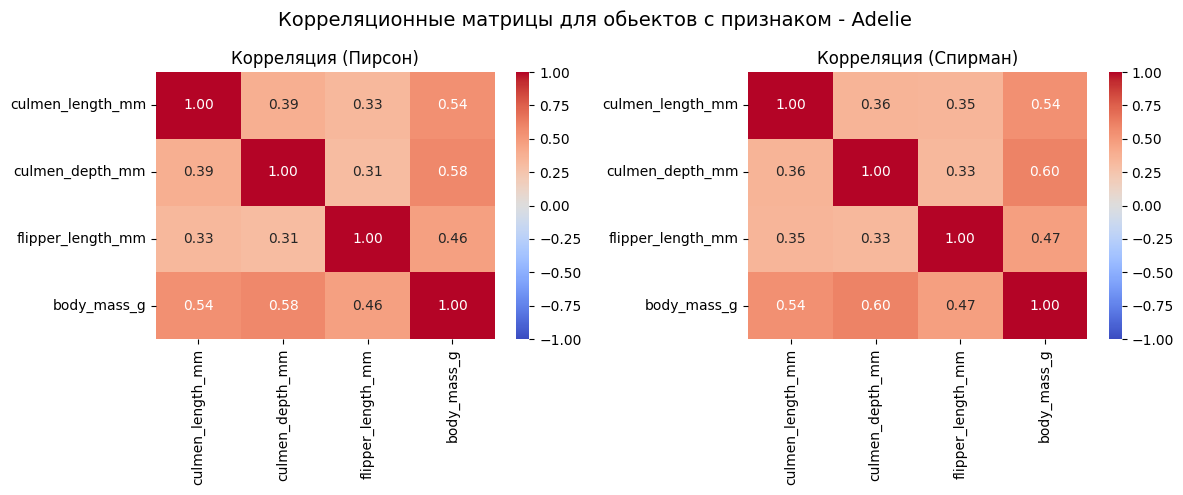


=== –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –¥–ª—è –æ–±—å–µ–∫—Ç–æ–≤: Chinstrap ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| –ü—Ä–∏–∑–Ω–∞–∫ 1         | –ü—Ä–∏–∑–Ω–∞–∫ 2         |   –ü–∏—Ä—Å–æ–Ω r |   p-value (–ü–∏—Ä—Å–æ–Ω) |   –°–ø–∏—Ä–º–µ–Ω œÅ |   p-value (–°–ø–∏—Ä–º–µ–Ω) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.654 |              0     |       0.672 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.472 |              5e-05 |       0.533 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.514 |              1e-05 |       0.525 |                   0 

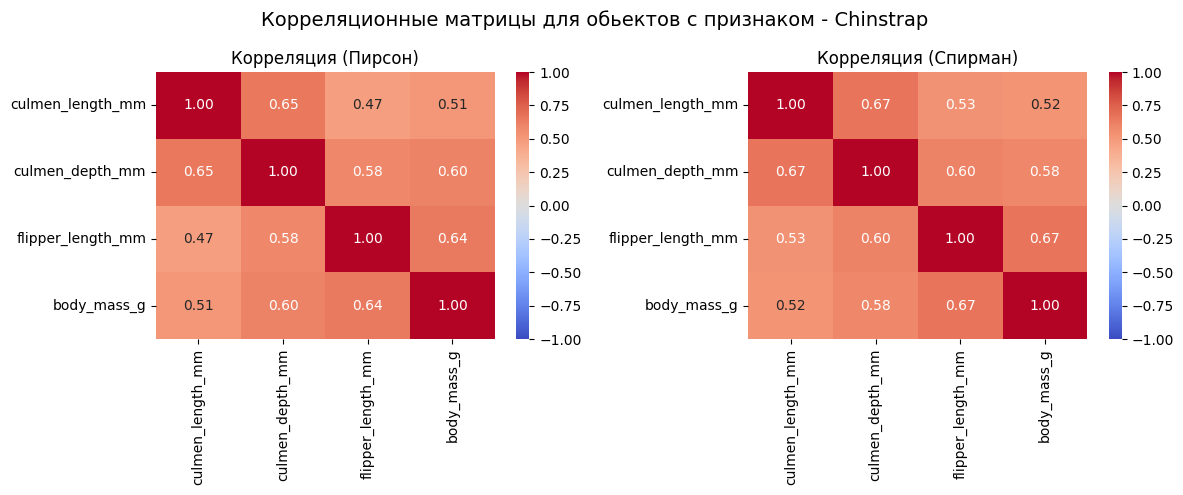


=== –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –¥–ª—è –æ–±—å–µ–∫—Ç–æ–≤: Gentoo ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| –ü—Ä–∏–∑–Ω–∞–∫ 1         | –ü—Ä–∏–∑–Ω–∞–∫ 2         |   –ü–∏—Ä—Å–æ–Ω r |   p-value (–ü–∏—Ä—Å–æ–Ω) |   –°–ø–∏—Ä–º–µ–Ω œÅ |   p-value (–°–ø–∏—Ä–º–µ–Ω) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.654 |                  0 |       0.652 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.664 |                  0 |       0.659 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.667 |                  0 |       0.684 |                   0 |
+

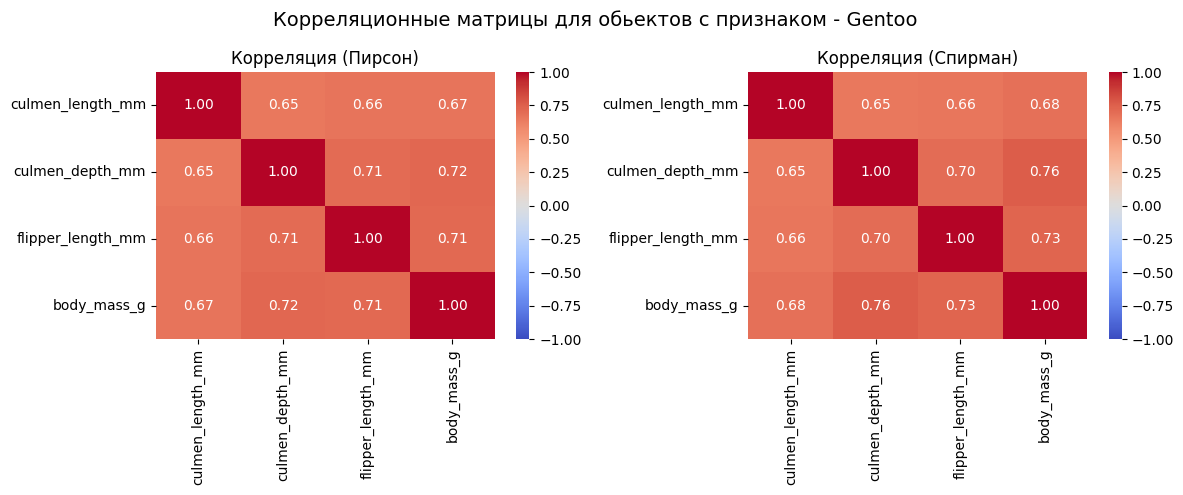



–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –ø–æ –∫–ª–∞—Å—Å—É: island

=== –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –¥–ª—è –æ–±—å–µ–∫—Ç–æ–≤: Torgersen ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| –ü—Ä–∏–∑–Ω–∞–∫ 1         | –ü—Ä–∏–∑–Ω–∞–∫ 2         |   –ü–∏—Ä—Å–æ–Ω r |   p-value (–ü–∏—Ä—Å–æ–Ω) |   –°–ø–∏—Ä–º–µ–Ω œÅ |   p-value (–°–ø–∏—Ä–º–µ–Ω) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.216 |            0.14461 |       0.187 |             0.20797 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.41  |            0.00417 |       0.444 |             0.00176 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.426 |       

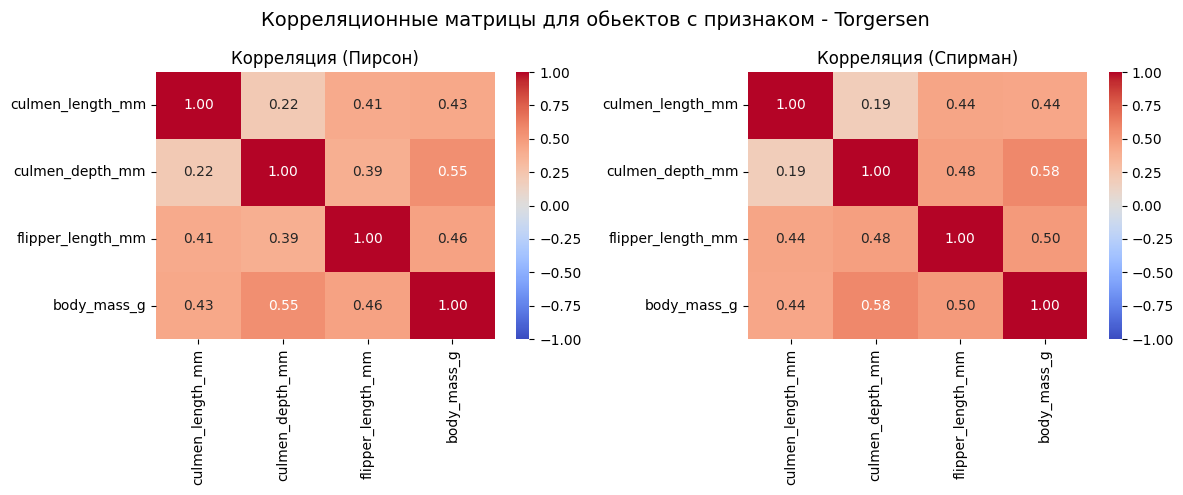


=== –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –¥–ª—è –æ–±—å–µ–∫—Ç–æ–≤: Biscoe ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| –ü—Ä–∏–∑–Ω–∞–∫ 1         | –ü—Ä–∏–∑–Ω–∞–∫ 2         |   –ü–∏—Ä—Å–æ–Ω r |   p-value (–ü–∏—Ä—Å–æ–Ω) |   –°–ø–∏—Ä–º–µ–Ω œÅ |   p-value (–°–ø–∏—Ä–º–µ–Ω) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.445 |                  0 |      -0.284 |             0.00024 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.868 |                  0 |       0.848 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.87  |                  0 |       0.856 |             0       |
+

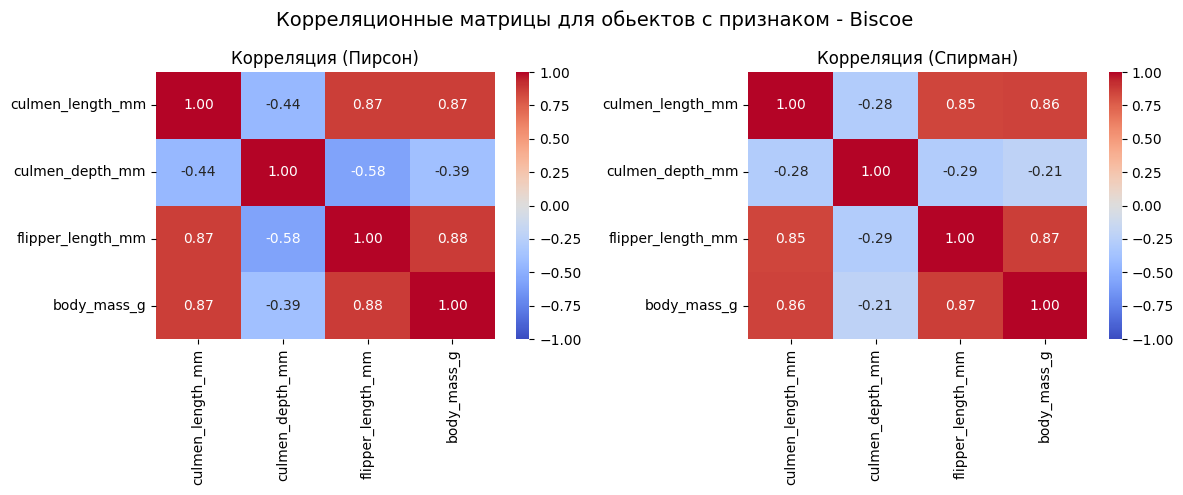


=== –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –¥–ª—è –æ–±—å–µ–∫—Ç–æ–≤: Dream ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| –ü—Ä–∏–∑–Ω–∞–∫ 1         | –ü—Ä–∏–∑–Ω–∞–∫ 2         |   –ü–∏—Ä—Å–æ–Ω r |   p-value (–ü–∏—Ä—Å–æ–Ω) |   –°–ø–∏—Ä–º–µ–Ω œÅ |   p-value (–°–ø–∏—Ä–º–µ–Ω) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |      0.365 |            3e-05   |       0.38  |             1e-05   |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.526 |            0       |       0.558 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.3   |            0.00075 |       0.337 |             0.00014 |
+-

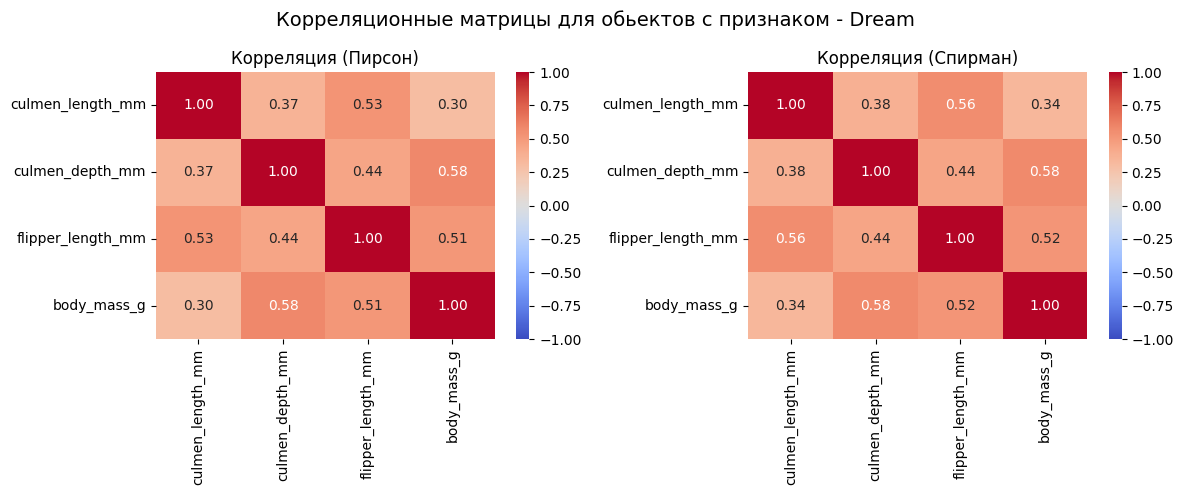



–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –ø–æ –∫–ª–∞—Å—Å—É: sex

=== –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –¥–ª—è –æ–±—å–µ–∫—Ç–æ–≤: MALE ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| –ü—Ä–∏–∑–Ω–∞–∫ 1         | –ü—Ä–∏–∑–Ω–∞–∫ 2         |   –ü–∏—Ä—Å–æ–Ω r |   p-value (–ü–∏—Ä—Å–æ–Ω) |   –°–ø–∏—Ä–º–µ–Ω œÅ |   p-value (–°–ø–∏—Ä–º–µ–Ω) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.395 |                  0 |      -0.277 |             0.00027 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.663 |                  0 |       0.641 |             0       |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.477 |               

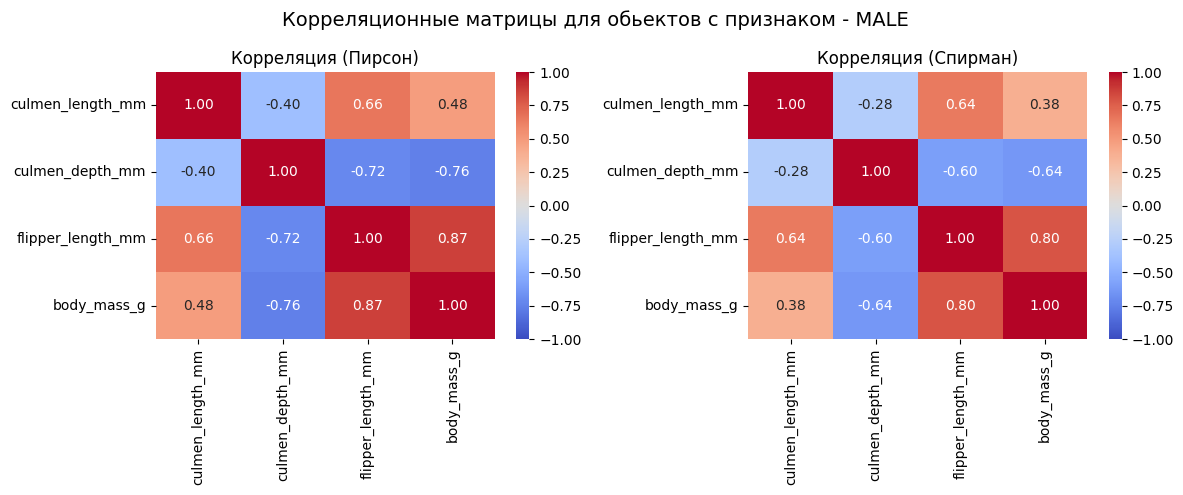


=== –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –¥–ª—è –æ–±—å–µ–∫—Ç–æ–≤: FEMALE ===
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| –ü—Ä–∏–∑–Ω–∞–∫ 1         | –ü—Ä–∏–∑–Ω–∞–∫ 2         |   –ü–∏—Ä—Å–æ–Ω r |   p-value (–ü–∏—Ä—Å–æ–Ω) |   –°–ø–∏—Ä–º–µ–Ω œÅ |   p-value (–°–ø–∏—Ä–º–µ–Ω) |
+===================+===================+============+====================+=============+=====================+
| culmen_length_mm  | culmen_depth_mm   |     -0.426 |                  0 |      -0.37  |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | flipper_length_mm |      0.571 |                  0 |       0.585 |                   0 |
+-------------------+-------------------+------------+--------------------+-------------+---------------------+
| culmen_length_mm  | body_mass_g       |      0.581 |                  0 |       0.575 |                   0 |
+

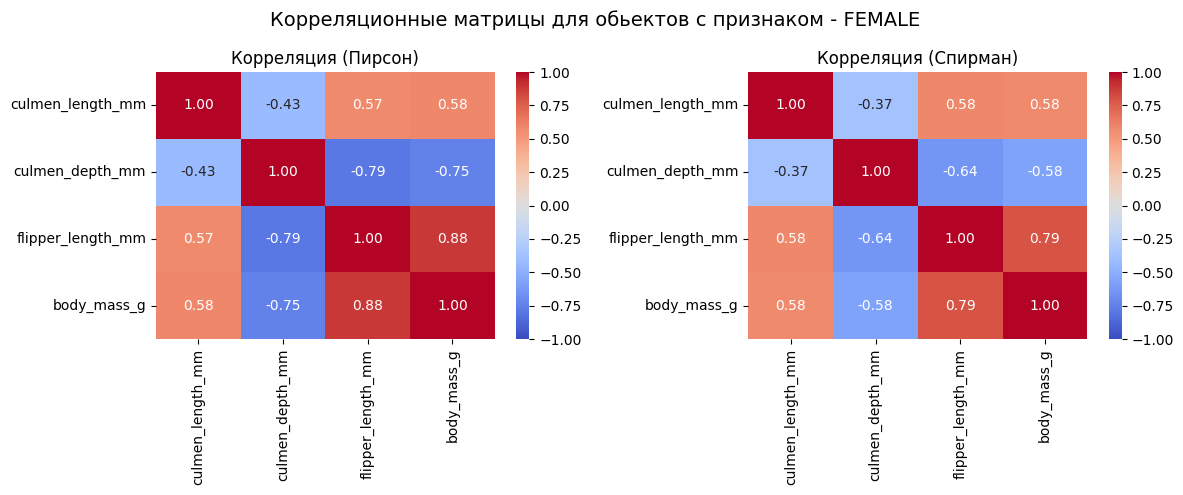

In [ ]:
for target in targets:
    display(Markdown(f"## üîπ –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –ø–æ –ø—Ä–∏–∑–Ω–∞–∫—É: **{target}**"))

    for cls in df[target].dropna().unique():
        display(Markdown(f"### ‚ñ∂ –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –¥–ª—è –æ–±—ä–µ–∫—Ç–æ–≤: **{cls}**"))
        
        # –¢–∞–±–ª–∏—Ü–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π
        correlation_table(df[df[target] == cls], features)
        
        # –¢–µ–ø–ª–æ–≤–∞—è –∫–∞—Ä—Ç–∞
        heatmap_corr(
            df[df[target] == cls],
            features,
            title=f"–ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω—ã–µ –º–∞—Ç—Ä–∏—Ü—ã –¥–ª—è –æ–±—ä–µ–∫—Ç–æ–≤ —Å –ø—Ä–∏–∑–Ω–∞–∫–æ–º '{cls}'"
        )

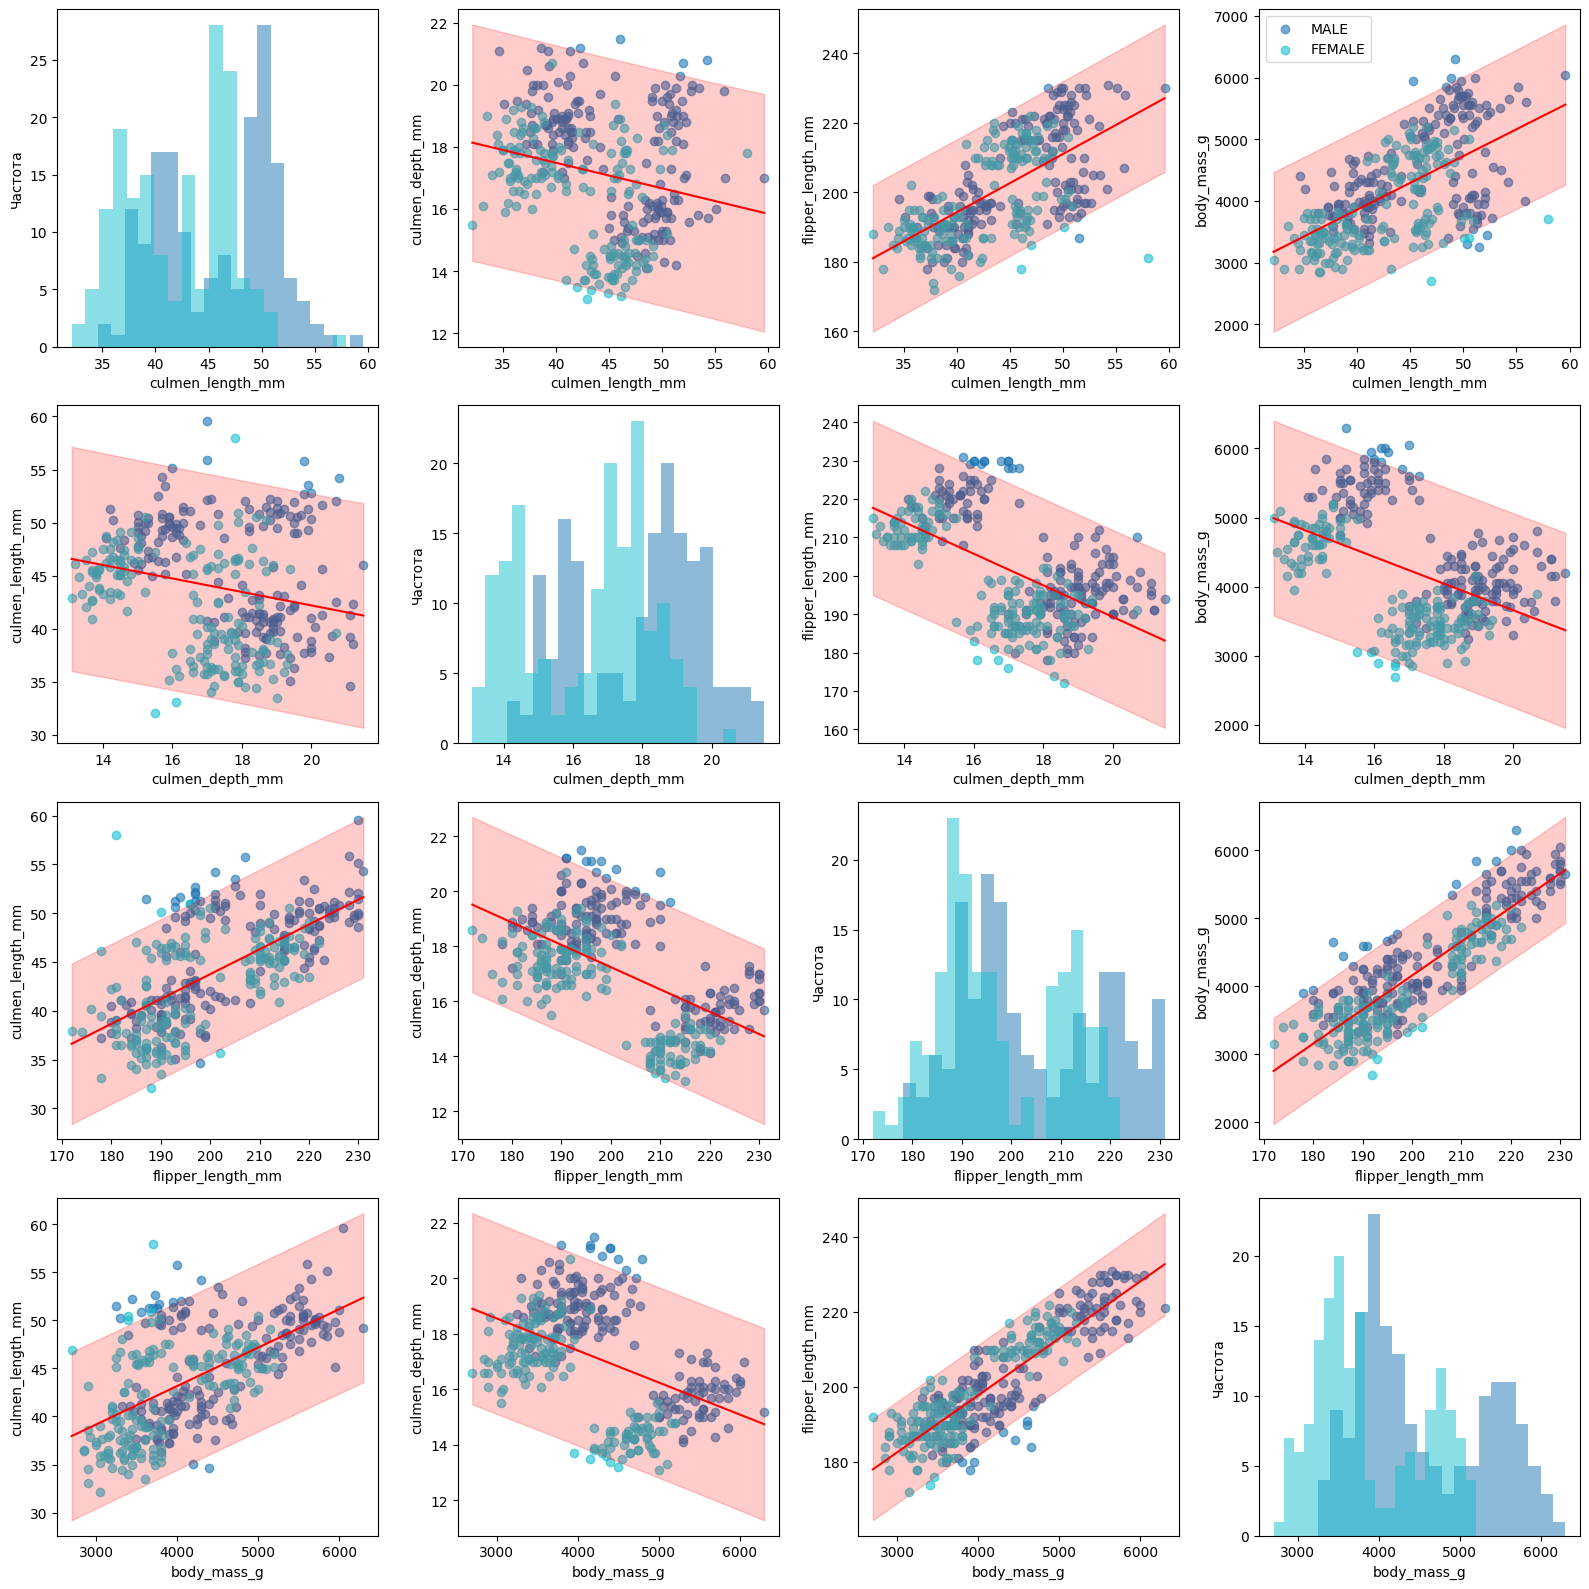

In [ ]:
pairplot_with_regression(df, class_col="sex", features=features)